## Three Main Methods for Simple Linear Regression

In this notebook I compare the three main ways to approach Simple (Univariate) Linear Regression:
   
    1. The Normal Equation
    2. Trial-and-Error method
    3. Gradient Descent algorithm
    
I will use the famous UCI ML housing dataset (see description below). 

In [1]:
from datetime import datetime
import time

dt_object = datetime.fromtimestamp(time.time())
dt_object = str(dt_object).split('.')[0]

Date, Time = dt_object.split(' ')
print('Revised on: ' + Date)

Revised on: 2020-07-29


In [2]:
# import modules and data
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import pandas as pd
import numpy as np

from sklearn.datasets import load_boston
boston=load_boston()

boston.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])

In [3]:
print(boston['DESCR'])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [4]:
# The average number of rooms per dwelling seems like a good predictor for house prices
X, y = boston['data'][:,5], boston['target']

for i in range(5):
    print('RM:' +str(X[i]) + '  MEDV:' +str(y[i]))

RM:6.575  MEDV:24.0
RM:6.421  MEDV:21.6
RM:7.185  MEDV:34.7
RM:6.998  MEDV:33.4
RM:7.147  MEDV:36.2


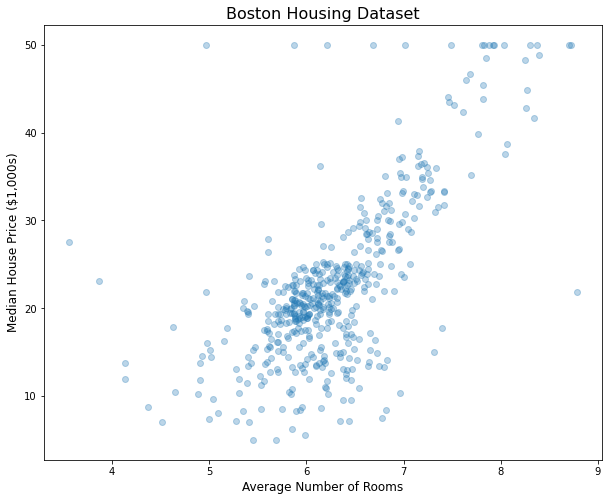

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = [10, 8]
plt.scatter(X, y, alpha=0.3)
plt.title('Boston Housing Dataset', size=16)
plt.ylabel('Median House Price ($1,000s)', size=12)
plt.xlabel('Average Number of Rooms', size=12)
plt.show()

## Normal Equation

The normal equation is a closed-form solution to the problem of minimizing $\theta_0, \theta_1$ in univariate linear regression. These parameters are the intercept  and slope of the best-fit line that minimizes the sum of squared errors from the predicted to the observed values. 

Note: the intercept is known as the bias term in machine learning, and the slope ($m$) or coefficient of an independent variable ($\theta x$) is known as the weight. These terms generalize beyond univariate linear regression.

The normal equation can be separated into two terms as follows:

\begin{align}
{\hat\theta} = (X^T . X)^{-1}   (X^T . y) \\
\end{align}


In [6]:
N = len(X)
X_bias = np.ones((N, 1))

X_reshaped = np.reshape(X, (N,1))
X_updated = np.append(X_bias, X_reshaped, axis=1)

XT = np.transpose(X_updated)  
XT_dot_X = XT.dot(X_updated)  

term1 = np.linalg.inv(XT_dot_X) 
term2 = XT.dot(y)  

In [7]:
Ɵ_hat = term1.dot(term2)

In [8]:
print("Incercept: " + str(Ɵ_hat[0]))
print("Slope: " + str(Ɵ_hat[1]))

Incercept: -34.67062077643459
Slope: 9.102108981179697


In [9]:
NORMAL_yhat = Ɵ_hat[1]* X + Ɵ_hat[0]

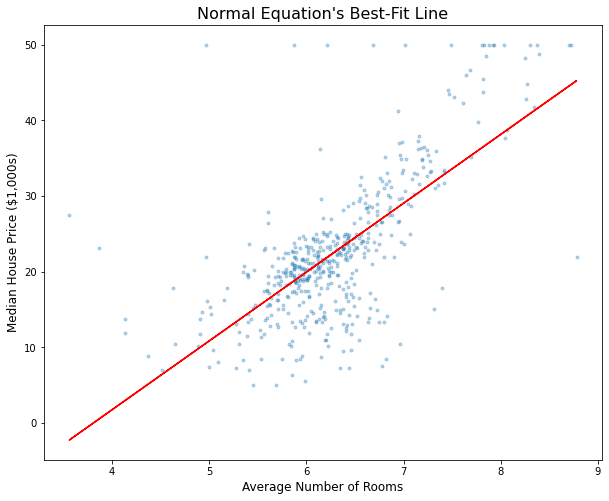

In [10]:
plt.rcParams['figure.figsize'] = [10, 8]
plt.plot(X, y, '.', alpha=0.3)
plt.title('Normal Equation\'s Best-Fit Line', size=16)
plt.ylabel('Median House Price ($1,000s)', size=12)
plt.xlabel('Average Number of Rooms', size=12)
plt.plot(X, NORMAL_yhat, '-', color='r')
plt.show()

## Cost Function

In machine learning we use a cost function to calculate the errors we made in our predictions. For regression, this is generally the mean squared error (MSE).

We can train an algorithm to minimize the MSE and then square (RMSE) for interpretability since the RMSE is expressed in the same units as the dependent variable - in our case, in 1,000s of dollars. 

In [56]:
def MSE_cost_function(x, y, w, b):
    """Calculates the Mean Squared Error given:
        x: dependent variable
        y: independent variable
        w: a weight, or coefficient, or slope (m) for the independent variable
        b: a bias term (intercept)
    """
    
    N = len(x)
    SSE = 0.0
    
    for i in range(N):
        SSE += (y[i] - (w*x[i] + b))**2
        
    return SSE / N

In [58]:
NORMAL_MSE = MSE_cost_function(X, y, Ɵ_hat[1], Ɵ_hat[0])

print('RMSE using normal equation: ' +str(round(np.sqrt(NORMAL_MSE), 4)))

RMSE using normal equation: 6.6031


The error is $6,603.10, and this is the best we can do with simple linear regression using average room size to predict the median house values, given the noise (uncertainty) in our data.

What we've done so far is not machine learning however: there is no learning involved, only a reasonable model.

More complex scenarios do not benefit from a simple mathematical model such as the normal equation, but use machine-learning methods (such as the gradient descent algorithm below) to learn from data and estimate the best-fit line (or best-fit hyperplane in the case of multivariate regression).

## Trial and Error 

What the normal equation gives us are two parameters, $\theta_0$ and $\theta_1$, which in simple linear regression are the intercept (or bias term) and the slope coefficient (or weight) for the line we're trying to fit through the data. 

Without the normal equation, those two parameters are what we're trying to teach the machine, or rather, have the machine learn from the data.

An intuitive way to find the best parameters is to test a variety of values (in combination) and capture the MSE as we test them to see whether we can get an intuition for which values would be best. This trial-and-error method is somewhat blind, so we need an intuition for where to start, how to initialize the parameters.

From the original scatterplot, we can guess that the intercept is negative (about -30) and the slope is positive (about 7). I created a search grid that test various slopes and intercepts.

In [59]:
# using intuition and a grid search

weight_list=[]
bias_list=[]
cost_history=[]
ct=0

for i in [w/10 for w in range(1, 150)]:
    for j in [b/10 for b in range(-400, -100, 5)]:
        
        MSE = MSE_cost_function(X, y, i, j)
        # ct += 1
        #print("ct: {:d}    w: {:.2f}    b: {:.2f}    c: {:.2f}".format(ct, i, j, MSE))
        
        weight_list.append(i)
        bias_list.append(j)
        cost_history.append(MSE)

In [60]:
data = {'iter':[i for i in range(1, len(cost_history)+1)],
       'weight':weight_list,
       'bias':bias_list,
       'mse':cost_history}

df = pd.DataFrame.from_dict(data)
df

,iter,weight,bias,mse
0,1,0.1,-40.0,3915.675238
1,2,0.1,-39.5,3854.020895
2,3,0.1,-39.0,3792.866552
3,4,0.1,-38.5,3732.212209
4,5,0.1,-38.0,3672.057867
5,6,0.1,-37.5,3612.403524
6,7,0.1,-37.0,3553.249181
7,8,0.1,-36.5,3494.594838
8,9,0.1,-36.0,3436.440495
9,10,0.1,-35.5,3378.786152


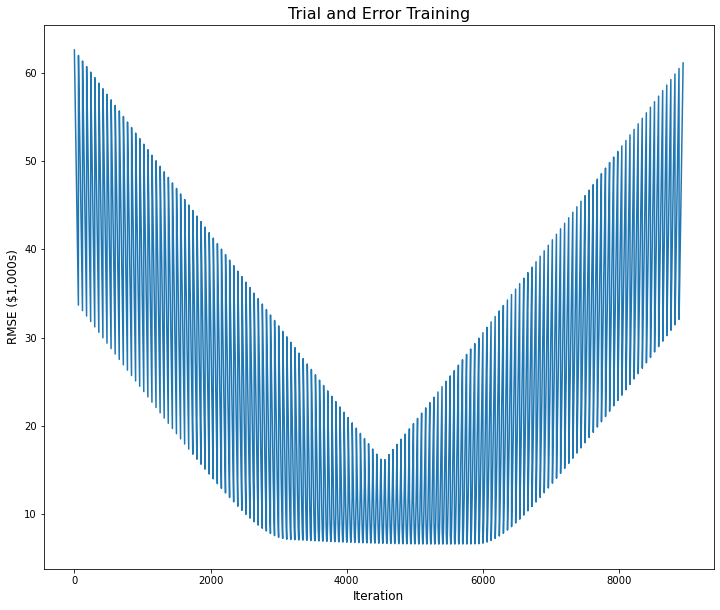

In [61]:
plt.rcParams['figure.figsize'] = [12, 10]
plt.plot(df['iter'], np.sqrt(df['mse']) , '-')
plt.title('Trial and Error Training', size=16)
plt.ylabel('RMSE ($1,000s)', size=12)
plt.xlabel('Iteration', size=12)
plt.show()

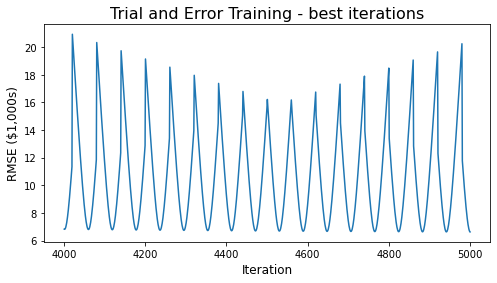

In [63]:
plt.rcParams['figure.figsize'] = [8, 4]
plt.plot(df['iter'][4000:5000,], np.sqrt(df['mse'][4000:5000,]) , '-')
plt.title('Trial and Error Training - best iterations', size=16)
plt.ylabel('RMSE ($1,000s)', size=12)
plt.xlabel('Iteration', size=12)
plt.show()

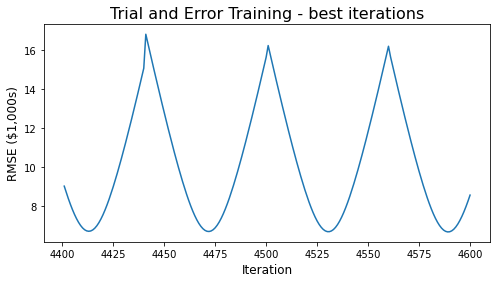

In [64]:
plt.rcParams['figure.figsize'] = [8, 4]
plt.plot(df['iter'][4400:4600,], np.sqrt(df['mse'][4400:4600,]) , '-')
plt.title('Trial and Error Training - best iterations', size=16)
plt.ylabel('RMSE ($1,000s)', size=12)
plt.xlabel('Iteration', size=12)
plt.show()

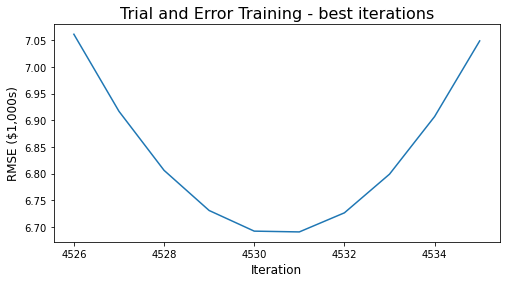

In [65]:
plt.rcParams['figure.figsize'] = [8, 4]
plt.plot(df['iter'][4525:4535,], np.sqrt(df['mse'][4525:4535,]) , '-')
plt.title('Trial and Error Training - best iterations', size=16)
plt.ylabel('RMSE ($1,000s)', size=12)
plt.xlabel('Iteration', size=12)
plt.show()

In [66]:
# lowest MSEs in tabular form
df.loc[4525:4535,]

,iter,weight,bias,mse
4525,4526,7.6,-27.5,49.863251
4526,4527,7.6,-27.0,47.843666
4527,4528,7.6,-26.5,46.324081
4528,4529,7.6,-26.0,45.304496
4529,4530,7.6,-25.5,44.784912
4530,4531,7.6,-25.0,44.765327
4531,4532,7.6,-24.5,45.245742
4532,4533,7.6,-24.0,46.226157
4533,4534,7.6,-23.5,47.706572
4534,4535,7.6,-23.0,49.686987


In [67]:
best_mse = np.min(df['mse'])
best_w, best_b = df[['weight','bias']][df['mse']  ==  best_mse].values[0]
best_yhat_i = best_w * X + best_b

In [74]:
print("Intercept:" + str(best_b))
print("Slope: " + str(best_w))
print("RMSE: " + str(round(np.sqrt(best_mse),4)))

Intercept:-34.0
Slope: 9.0
RMSE: 6.6035


In [75]:
# visualizing the entire effort with a scatter plot

y_hats = []
for i in range(len(df)):
    y_hat = df['weight'][i] * X + df['bias'][i]
    y_hats.append(y_hat)

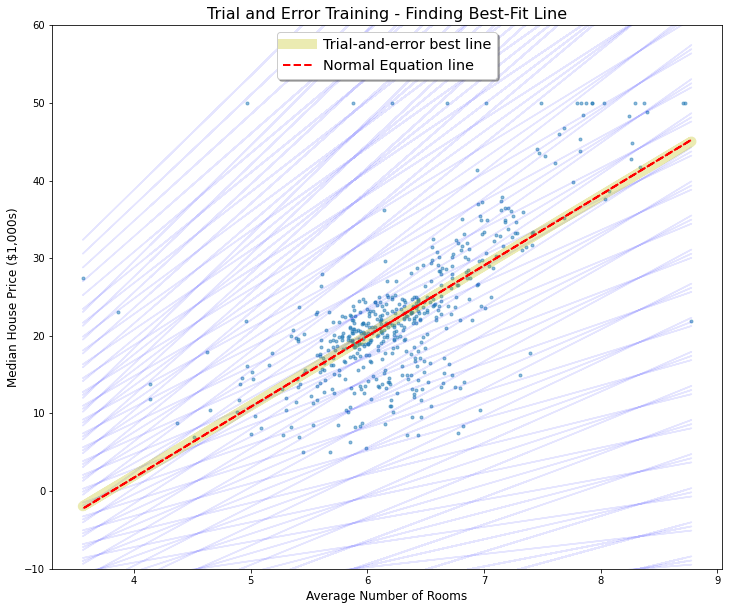

In [76]:
plt.rcParams['figure.figsize'] = [12, 10]
fig, ax = plt.subplots()
ax.plot(X, y, '.', alpha=0.5)

plt.title('Trial and Error Training - Finding Best-Fit Line', size=16)
plt.ylabel('Median House Price ($1,000s)', size=12)
plt.xlabel('Average Number of Rooms', size=12)
plt.ylim(-10,60)

# plotting every 100th iteration's predictions
for i in range(0,len(df), 100):
    ax.plot(X, y_hats[i], '-', color='b', alpha=0.1)

ax.plot(X, best_yhat_i, '-', color='y', linewidth=10, alpha=0.3, label='Trial-and-error best line')
ax.plot(X, NORMAL_yhat, '--', color='r', linewidth=2, label='Normal Equation line')

legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')
plt.show()

With a good guess as to the initial parameters and a fine-enough grid, trial and error can work to zoom in on the best line, but it takes some effort and is not the most efficient method.

## Gradient Descent

There are many books and online resources that explain how gradient descent works, and the various flavors it takes (batch, mini-batch, stochastic). I'm not going to teach it, just implement it in a very basic form. 

The main idea is that there's an "error landscape" of sorts, which in linear regression is a convex bowl, and based on a guess to initialize the weight and bias parameters, we calculate the gradient or inclination of our terrain and step, via a learning rate, toward the bottom of the bowl, minimizing the error (the MSE in our case).

For this we need a function that updates the weights (the weight and bias) given their partial derivatives and a function that does so in various iterations.

In [77]:
def update_weights(x, y, w, b, eta0):
    """Update weight and bias term given:
       ---------------------------------
           x: independent variable
           y: dependent variable
           w: weight (coefficient, or slope m)
           b: bias term (intercept)
           eta0: learning rate hyperparameter
       
       Calculates weight and bias partial derivatives using the chain rule.
    """
    
    w_deriv = 0
    b_deriv = 0
    N = len(x)

    # Calculate partial derivatives
    for i in range(N):
        # for weight: -2x(y - (mx + b))
        w_deriv += -2*x[i] * (y[i] - (w*x[i] + b))
        # for slope: -2(y - (mx + b))
        b_deriv += -2*(y[i] - (w*x[i] + b))

    # We subtract because the derivatives point in direction of steepest ascent
    w -= (w_deriv / N) * eta0
    b -= (b_deriv / N) * eta0

    return w, b

In [78]:
# what is the update for new weights given the same starting point?
# let's take a look at the top of the original trial-and-error dataframe

df.head()

,iter,weight,bias,mse
0,1,0.1,-40.0,3915.675238
1,2,0.1,-39.5,3854.020895
2,3,0.1,-39.0,3792.866552
3,4,0.1,-38.5,3732.212209
4,5,0.1,-38.0,3672.057867


In [80]:
# Iteration 1

# using our gradient descent function we calculate:

# the new weight and bias for the first iteration
w1, b1 = update_weights(X, y, w=.1, b=-21, eta0=.001)

# the new cost for the first iteration
c1 = MSE_cost_function(X, y, w1, b1)

# that went a lot faster!
w1, b1, c1

(0.6481468093885377, -20.91419131422925, 1629.0961108357862)

In [81]:
# Iteration 2
w2, b2 = update_weights(X, y, w1, b1, eta0=.001)
c2 = MSE_cost_function(X, y, w2, b2)
w2, b2, c2

(1.1513750249655337, -20.83544405040524, 1380.2874785443057)

In [82]:
# Iteration 3
w3, b3 = update_weights(X, y, w2, b2, eta0=.001)
c3 = MSE_cost_function(X, y, w3, b3)
w3, b3, c3

(1.6133659320982718, -20.76317949180548, 1170.5897136177991)

In [87]:
# We can create a function that does this training automatically

def GradientDescent(x, y, w, b, eta0, iters):
    """Implements Gradient Descent given:
       ----------------------------------
           x = independent variable
           y = dependent variable
           w = the coefficient, or weight of the independent variable (slope)
           b = the bias term (intercept)
           eta0 = the learning rate hyperparameter
           iters = the number of iterations for training
        
       Calculates the MSE at every iteration, stores weights, biases, and MSEs and 
       returns a dictionary with the best parameters and entire training history.

    """
    import pandas as pd
    
    w_history = []
    b_history = []
    MSE_history = []

    for i in range(iters):
        w,b = update_weights(x, y, w, b, eta0)

        w_history.append(w)
        b_history.append(b)
        
        # Cost
        MSE = MSE_cost_function(x, y, w, b)
        MSE_history.append(MSE)
        
        # print out progress to console
        if i % 100 == 0:
            print("iter={:d}    weight={:.2f}    bias={:.2f}    rmse={:.5f}".format(i, w, b, np.sqrt(MSE))) 

    temp_dict = {'iter':[x for x in range(1, iters+1)], 
                 'weight':w_history,
                 'bias':b_history, 
                 'mse':MSE_history}
    
    best_MSE = min(temp_dict['mse'])
    temp_df = pd.DataFrame.from_dict(temp_dict)
    
    best_w = float(temp_df['weight'][temp_df['mse'] == best_MSE])
    best_b = float(temp_df['bias'][temp_df['mse'] == best_MSE])
    
    # return a dict 
    return {'best_params':{'weight':best_w, 'bias':best_b},
            'best_MSE':best_MSE, 
            'iter':[x for x in range(1, iters+1)], 
            'weight':w_history,
            'bias':b_history, 
            'mse':MSE_history} 

In [88]:
mod1 = GradientDescent(X, y, w=5, b=-35, eta0=.0001, iters=1500)

iter=0    weight=5.03    bias=-34.99    rmse=26.87640
iter=100    weight=7.29    bias=-34.64    rmse=13.20970
iter=200    weight=8.28    bias=-34.48    rmse=8.29727
iter=300    weight=8.71    bias=-34.42    rmse=6.96203
iter=400    weight=8.90    bias=-34.39    rmse=6.67387
iter=500    weight=8.99    bias=-34.37    rmse=6.61685
iter=600    weight=9.02    bias=-34.37    rmse=6.60580
iter=700    weight=9.04    bias=-34.37    rmse=6.60367
iter=800    weight=9.05    bias=-34.36    rmse=6.60326
iter=900    weight=9.05    bias=-34.36    rmse=6.60318
iter=1000    weight=9.05    bias=-34.36    rmse=6.60316
iter=1100    weight=9.05    bias=-34.36    rmse=6.60316
iter=1200    weight=9.05    bias=-34.36    rmse=6.60316
iter=1300    weight=9.05    bias=-34.36    rmse=6.60316
iter=1400    weight=9.05    bias=-34.36    rmse=6.60316


In [89]:
# the best weight is 6.7 and the best bias term is -19.98 according to this method
mod1['best_params']

{'weight': 9.053864631700588, 'bias': -34.363847889566586}

In [95]:
# the best RMSE is not better than the trial-and-error method so far
print('Best RMSE: ' +str(round(np.sqrt(mod1['best_MSE']),4)))

Best RMSE: 6.6032


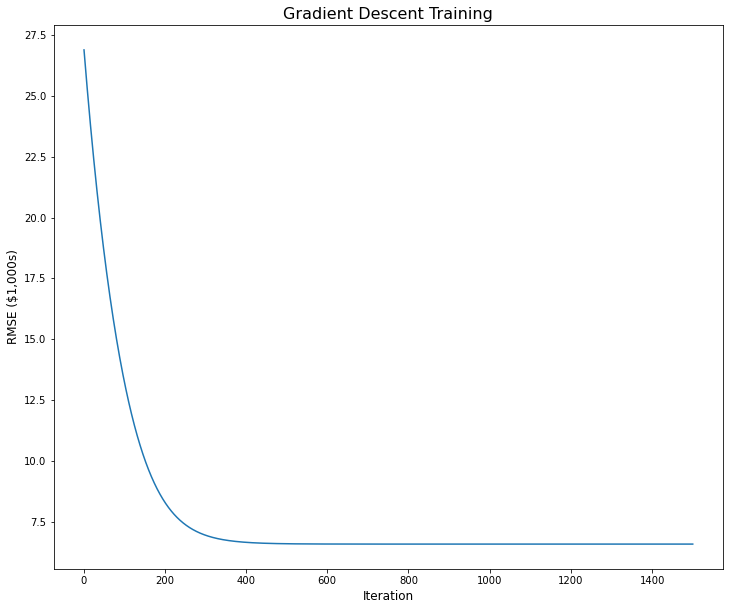

In [98]:
# Visualize cost descent

plt.rcParams['figure.figsize'] = [12, 10]
plt.plot(mod1['iter'], np.sqrt(mod1['mse']), '-')
plt.title('Gradient Descent Training', size=16)
plt.ylabel('RMSE ($1,000s)', size=12)
plt.xlabel('Iteration', size=12)

plt.show()

It is clear that gradient descent is a much better method than trial and error, the error decreases steadily until the machine stops learning and gains are too low for us to continue training the machine. In this case, stopping at iteration 500 would've been sufficient. 

Gradient descent is sensitive to initial parameters and learning rate. Starting at a weight of 2 and bias of -40 would not have learned the best parameters.Setting a learning rate of 0.05 would not have been granular enough to approach the best line.

In [99]:
# We can visualize the learning by first calculating the predictions

y_hats = []
for i in range(len(mod1['iter'])):
    y_hat = mod1['weight'][i] * X + mod1['bias'][i]
    y_hats.append(y_hat)
    
best_yhat = mod1['best_params']['weight'] * X + mod1['best_params']['bias']

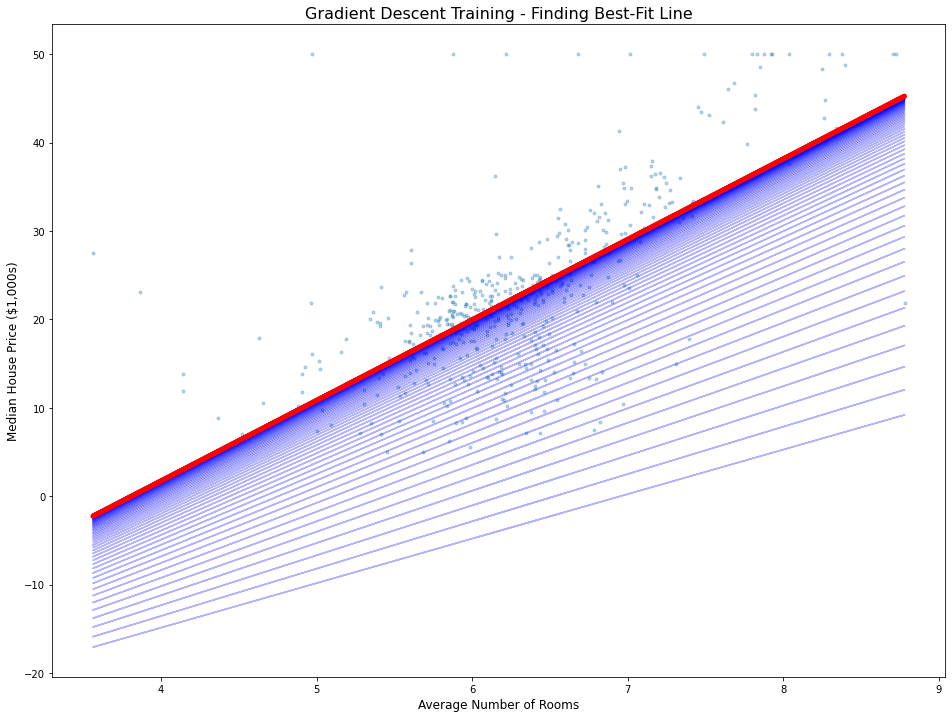

In [100]:
plt.rcParams['figure.figsize'] = [16, 12]
plt.plot(X, y, '.', alpha=0.3)

plt.title('Gradient Descent Training - Finding Best-Fit Line', size=16)
plt.ylabel('Median House Price ($1,000s)', size=12)
plt.xlabel('Average Number of Rooms', size=12)

for i in range(len(mod1['iter'])):
    
    # plotting every 10th iteration's predictions
    if i%10 == 0:
        plt.plot(X, y_hats[i], '-', color='b', alpha=0.3)


# NORMAL EQUATION comparison
plt.plot(X, NORMAL_yhat, '-', color='r', linewidth=5)

plt.show()

We see how the gradient descent learns the best-fit line by fitting the slope and bias gradually and methodically. It is sensitive to initial parameters and learning rate, but it is a more reasonable and cost-efficient approach.